In [13]:
import numpy as np
import matplotlib.pyplot as plt
from hamming_distance_distribution import hamming_distance
from annealing import adjacency_from_couplings
from graph import is_connected

In [14]:
def annealing_by_connection(blocksize, fname):
    """Counts the number of correct detections and the number of all detections for
    connected graphs and for unconnected graphs separately. 
    
    Parameters:
    - blocksize     number of datapoints which should be used for counting
    - fname         data file to read the data from

    Returns:
    - N_correct_connected       number of correct detections among the subset of all connected graphs
    - N_correct_unconnected     number of correct detections among the subset of all unconnected graphs
    - N_connected               total number of connected graphs
    - N_unconnected             total number of unconnected graphs
    """
    # read data from file
    data = np.load(fname, allow_pickle=True).item()

    N_blocks = int(data['size']/blocksize)
    N_correct_connected     = np.zeros(N_blocks)
    N_correct_unconnected   = np.zeros(N_blocks)
    N_connected             = np.zeros(N_blocks)
    N_unconnected           = np.zeros(N_blocks)

    for j in range(N_blocks):

        for i in range(blocksize):
            # get annealing results
            J_n         = data["J_n"][j*blocksize + i]
            alpha       = data["alpha"][j*blocksize + i]
            gs_array1   = data["gs_array"][j*blocksize + i]
      
            # classify annealing result
            d_Hamming = hamming_distance(alpha, gs_array1)
            connected = is_connected(adjacency_from_couplings(J_n))

            if connected:
                N_connected[j] += 1
                if d_Hamming==0:
                    N_correct_connected[j] += 1

            if not connected:
                N_unconnected[j] += 1
                if d_Hamming==0:
                    N_correct_unconnected[j] += 1

    return N_correct_connected, N_correct_unconnected, N_connected, N_unconnected


In [15]:
# ---------- Parameters for reading data file -------------
paths = ["./annealing_data/", "./exhaustive_search_data/"]
path = paths[1]

N = 5               # number of users
M = 4               # length of id-sequence for every user
K = 100              # number of antennas
xi = 0              # std of thermal noise

thres_min = 0         # rule=1: 0.0
thres_max = 4         # rule=1: 0.4
thres_step = 1       # rule=1: 0.01
neglection_rule = 3     # 1: threshold method, 2: neglect a certain number of couplings, 3: set maximum degree for each node

blocksize = 100       # resolution of y axis (equal to N_repeat from other program)

In [16]:
path += f"rule_{neglection_rule}/"

# ---------- Program ----------
thres_min = float(thres_min)
thres_max = float(thres_max)

N_neglection_thres = int((thres_max-thres_min)/thres_step)+1
data = np.load(path + f"neglection_thres_{thres_min}_N_5_M_4_K_100_xi_0.npy", allow_pickle=True).item()

N_blocks = int(data["size"]/blocksize)
print(f"file includes {data['size']} runs which get split into {N_blocks} blocks of size {blocksize}.")
N_stat = N_blocks

N_correct_connected     = np.zeros(shape=(N_neglection_thres, N_stat))
N_correct_unconnected   = np.zeros(shape=(N_neglection_thres, N_stat))
N_connected             = np.zeros(shape=(N_neglection_thres, N_stat))
N_unconnected           = np.zeros(shape=(N_neglection_thres, N_stat))

neglection_thres = np.zeros(N_neglection_thres)

for i in range(N_neglection_thres):
    neglection_thres[i] = thres_min + i*thres_step
    neglection_thres[i] = np.round(neglection_thres[i], 6)

    fname = path + f"neglection_thres_{neglection_thres[i]}_N_{N}_M_{M}_K_{K}_xi_{xi}.npy"
    result = annealing_by_connection(blocksize, fname)
    print(f"{i}: {len(result[0])} blocks in {fname}")

    N_correct_connected[i]      = result[0]
    N_correct_unconnected[i]    = result[1]
    N_connected[i]              = result[2]
    N_unconnected[i]            = result[3]


file includes 5000 runs which get split into 50 blocks of size 100.
0: 50 blocks in ./exhaustive_search_data/rule_3/neglection_thres_0.0_N_5_M_4_K_100_xi_0.npy
1: 50 blocks in ./exhaustive_search_data/rule_3/neglection_thres_1.0_N_5_M_4_K_100_xi_0.npy
2: 50 blocks in ./exhaustive_search_data/rule_3/neglection_thres_2.0_N_5_M_4_K_100_xi_0.npy
3: 50 blocks in ./exhaustive_search_data/rule_3/neglection_thres_3.0_N_5_M_4_K_100_xi_0.npy
4: 50 blocks in ./exhaustive_search_data/rule_3/neglection_thres_4.0_N_5_M_4_K_100_xi_0.npy


In [17]:
# ratios
if len(np.where(N_connected==0)[0])>0:
    print(f"Division by zero: N_connected   = 0 at {np.where(N_connected==0)}")
if len(np.where(N_unconnected==0)[0])>0:
    print(f"Division by zero: N_unconnected = 0 at {np.where(N_unconnected==0)}")

r_correct_connected     = N_correct_connected   /   N_connected
r_correct_unconnected   = N_correct_unconnected /   N_unconnected

Division by zero: N_connected   = 0 at (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]))
Division by zero: N_unconnected = 0 at (array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

/tmp/ipykernel_4574/3773222365.py:7: RuntimeWarning: invalid value encountered in divide
  r_correct_connected     = N_correct_connected   /   N_connected
/tmp/ipykernel_4574/3773222365.py:8: RuntimeWarning: invalid value encountered in divide
  r_correct_unconnected   = N_correct_unconnected /   N_unconnected


In [18]:
# statistics
r_correct_connected_mean    = np.mean(r_correct_connected, axis=1)
dr_correct_connected        = np.std(r_correct_connected, axis=1)
dr_mean_correct_connected   = dr_correct_connected / np.sqrt(N_stat)

r_correct_unconnected_mean  = np.mean(r_correct_unconnected, axis=1)
dr_correct_unconnected      = np.std(r_correct_unconnected, axis=1)
dr_mean_correct_unconnected = dr_correct_unconnected / np.sqrt(N_stat)

total number of runs per neglection threshold: 100
obtained ratios:
correct connected: 
[       nan        nan 0.92844271 0.96357935 0.9896    ] +- [       nan        nan 0.00580073 0.00282235 0.00138449], 
unconnected: 
[0.5444     0.7658     0.86837327 0.96163348        nan] +- [0.05650345 0.04459103 0.04347676 0.0614759         nan]


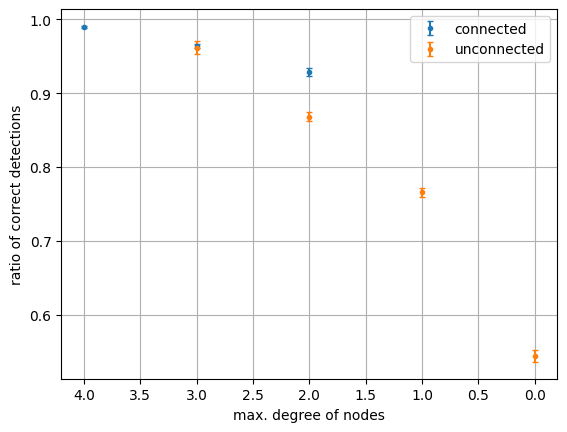

In [19]:
# Results

print(f"total number of runs per neglection threshold: {blocksize}")
print("obtained ratios:")
print(f"correct connected: \n{r_correct_connected_mean} +- {dr_mean_correct_connected}, \nunconnected: \n{r_correct_unconnected_mean} +- {dr_correct_unconnected}")

# Plotting
xlabels = ["", r"neglection threshold $\eta$", "number of neglected matrix elements", "max. degree of nodes"]
plt.errorbar(x=neglection_thres, y=r_correct_connected_mean, yerr=dr_mean_correct_connected, label="connected", capsize=2, ls="none", marker=".")
plt.errorbar(x=neglection_thres, y=r_correct_unconnected_mean, yerr=dr_mean_correct_unconnected, label="unconnected", capsize=2, ls="none", marker=".")
plt.xlabel(xlabels[neglection_rule])
plt.ylabel("ratio of correct detections")
plt.legend()
plt.grid()
if neglection_rule == 3:            # this is done so that in the diagram the original, unmodified problem is always on the left and the most modified problem is on the right. 
    plt.gca().invert_xaxis()
plt.show()

UER = 1 - r


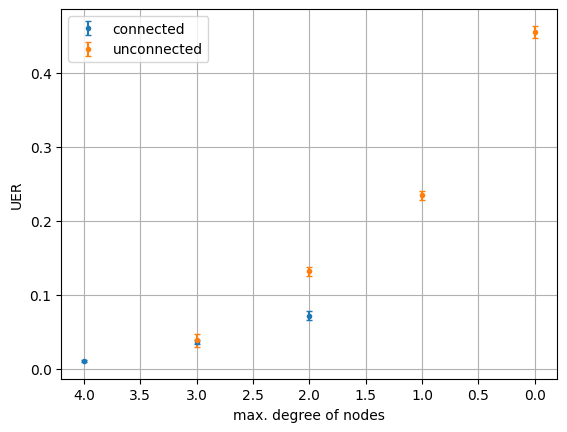

In [21]:
# use the same data but show it in a different fashion: The user error rate
print(f"UER = 1 - r")
# Plotting
plt.errorbar(x=neglection_thres, y=1-r_correct_connected_mean, yerr=dr_mean_correct_connected, label="connected", capsize=2, ls="none", marker=".")
plt.errorbar(x=neglection_thres, y=1-r_correct_unconnected_mean, yerr=dr_mean_correct_unconnected, label="unconnected", capsize=2, ls="none", marker=".")
plt.xlabel(xlabels[neglection_rule])
plt.ylabel("UER")
plt.legend()
plt.grid()
if neglection_rule == 3: 
    plt.gca().invert_xaxis()
plt.show()